In [90]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential

In [91]:
df_1 = pd.read_csv('dc_part.csv')
df_2 = pd.read_csv('chenqin5%.csv')
df_3 = pd.read_csv('miaoqin_part.csv')
df_4 = pd.read_csv('yunDataN.csv')
print(df_1.shape,df_2.shape,df_3.shape,df_4.shape)

(124293, 147) (124293, 92) (124293, 162) (124293, 74)


# Mergeing the 4 parts of the datasets with the zero-rate less than 95%

In [92]:
data_parts=[df_1,df_2,df_3,df_4]
useful=[] # the column names for each parts that have less than 95% zeros
for ele in data_parts:
  useful_sub=[]
  for col in ele.columns:
    if ele[col].isin([0]).sum()/ele.shape[0]<0.95:
      useful_sub.append(col)
  useful.append(useful_sub)
useful[2]=useful[2][1:]  # drop unuseful column_name in the 4th parts

In [93]:
df_1 = df_1.loc[:,useful[0]]
df_2 = df_2.loc[:,useful[1]]
df_3 = df_3.loc[:,useful[2]]
df_4 = df_4.loc[:,useful[3]]

In [94]:
result = pd.concat([df_1,df_2,df_3,df_4], axis=1, sort=False) # combine the dateset

In [95]:
result.head()

,_key_client_id,_key_occurreddate_month,Total_incident_count,response_variable,incident_subcatgry_unknown_piv,prgcontct_other_organisation_piv,prgcontct_lwb_worker_piv,prgcontct_both_client_and_carer_piv,prgcontct_department_piv,prgcontct_family_piv,prgcontct_carer_piv,prgcontct_client_piv,prgcontct_meeting_group_of_people_piv_sum_n_days,prgcontct_other_organisation_piv_sum_n_days,prgcontct_educational_institution_piv_sum_n_days,prgcontct_lwb_worker_piv_sum_n_days,prgcontct_both_client_and_carer_piv_sum_n_days,prgcontct_health_professional_piv_sum_n_days,prgcontct_department_piv_sum_n_days,prgcontct_other_stakeholder_piv_sum_n_days,prgcontct_family_piv_sum_n_days,prgcontct_carer_piv_sum_n_days,prgcontct_client_piv_sum_n_days,prgcontct_meeting_group_of_people_piv_days_since,prgcontct_other_organisation_piv_days_since,prgcontct_meeting_lwb_internal_only_piv_days_since,prgcontct_educational_institution_piv_days_since,prgcontct_employer_piv_days_since,prgcontct_lwb_worker_piv_days_since,prgcontct_police_piv_days_since,prgcontct_both_client_and_carer_piv_days_since,prgcontct_health_professional_piv_days_since,prgcontct_department_piv_days_since,prgcontct_other_stakeholder_piv_days_since,prgcontct_family_piv_days_since,prgcontct_carer_piv_days_since,prgcontct_client_piv_days_since,progsubjcat_information_provided_piv,progsubjcat_case_discussion_planning_piv,progsubjcat_i_sight_client_incident_system_generated_piv,...,rowtype_reference_piv_avg_n_days,rowtype_client_address_addition_piv_days_since,rowtype_rp_end_piv_days_since,rowtype_rp_start_piv_days_since,rowtype_progress_note_piv_days_since,rowtype_diagnosis_piv_days_since,rowtype_medictn_start_piv_days_since,rowtype_client_plan_start_piv_days_since,rowtype_client_plan_end_piv_days_since,rowtype_keyworker_change_piv_days_since,rowtype_reference_piv_days_since,rowtype_medictn_end_piv_days_since,rowtype_plcment_end_piv_days_since,rowtype_incident_piv_days_since,rowtype_plcment_start_piv_days_since,rowtype_program_primary_service_type_start_piv_days_since,rowtype_client_alert_start_piv_days_since,rowtype_client_address_addition_piv_lag01,rowtype_rp_end_piv_lag01,rowtype_rp_start_piv_lag01,rowtype_progress_note_piv_lag01,rowtype_diagnosis_piv_lag01,rowtype_medictn_start_piv_lag01,rowtype_client_plan_start_piv_lag01,rowtype_client_plan_end_piv_lag01,rowtype_keyworker_change_piv_lag01,rowtype_reference_piv_lag01,rowtype_medictn_end_piv_lag01,rowtype_plcment_end_piv_lag01,rowtype_incident_piv_lag01,rowtype_plcment_start_piv_lag01,rowtype_program_primary_service_type_start_piv_lag01,rowtype_client_alert_start_piv_lag01,status_placement,status_client_plan,status_rp_mechanical_restraint,status_rp_restricted_access,status_rp_chemical_restraint,status_rp_other,Incident
0,0000D172-EA88-432F-8235-9FAA00D29072,2019-04-01T00:00:00.0,0,0,29,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,2868,3650,3650,0,1,0,...,1,603,355,376,890,515,492,761,555,345,2,425,469,703,527,577,488,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,1,2,2,2,0
1,0000D172-EA88-432F-8235-9FAA00D29072,2019-05-01T00:00:00.0,0,0,31,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,22,3650,3650,0,0,0,...,1,603,355,376,21,515,492,761,555,345,0,425,469,703,527,577,488,1,1,1,2,1,1,1,1,1,38,1,1,1,1,1,1,2,2,1,2,2,2,0
2,0000D172-EA88-432F-8235-9FAA00D29072,2019-06-01T00:00:00.0,0,0,31,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,52,3650,3650,0,0,0,...,1,559,355,376,51,515,492,761,555,345,0,425,469,703,527,577,488,1,1,1,1,1,1,1,1,1,46,1,1,1,1,1,1,2,2,1,2,2,2,0
3,0000D172-EA88-432F-8235-9FAA00D29072,2019-07-01T00:00:00.0,0,0,32,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,83,3650,483,0,1,0,...,1,21,355,376,20,515,492,761,555,345,0,425,469,703,527,577,488,3,1,1,1,1,1,1,1,1,40,1,1,1,1,1,1,2,2,1

### Parse 'Dates' and indexs it

In [96]:
result.to_csv('Dataconcate.csv')

In [97]:
Dataset=pd.read_csv('Dataconcate.csv',parse_dates=['_key_occurreddate_month'],index_col=['_key_client_id','_key_occurreddate_month'])

In [98]:
Dataset.drop(['Unnamed: 0','response_variable'],axis=1).head()

Total_incident_count  ...  Incident
_key_client_id                       _key_occurreddate_month                        ...          
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                  0  ...         0
                                     2019-05-01                                  0  ...         0
                                     2019-06-01                                  0  ...         0
                                     2019-07-01                                  0  ...         0
                                     2019-08-01                                  0  ...         0

[5 rows x 209 columns]

In [99]:
client_id=list(Dataset.index.get_level_values(0)) # the value of '_key_client_id' indexe

### Remove the Useless records

In [100]:
from collections import Counter
occurrences = Counter(client_id)

In [101]:
used_id=[]
usedless_id=[]
for key, value in occurrences.items():
  if value==12:  # number can be changed
    used_id.append(key)
  else:
    usedless_id.append(key)

In [102]:
print(f'Useful client:  {len(used_id):d}\nUseless client: {len(usedless_id):d}')

Useful client:  7380
Useless client: 7007


In [103]:
# remove the rows that the record of client is less than 12 month 
Dataset=Dataset.drop(usedless_id,level=0) 
Dataset.shape

(88560, 211)

In [104]:

Dataset.drop(['Unnamed: 0','response_variable'],axis=1,inplace=True)

## Perparing Dateset for Modelling

### Spliting to Train and Test Set

In [105]:
split=int(0.9*len(used_id))
train_index=used_id[:split] # the clients who will in trainset
test_index=used_id[split:] # the clients who will in testset

# Train dataset
train=Dataset.loc[train_index]
train_x = train.drop('Incident',axis=1)
train_y = train.Incident

# Test Dataset
test=Dataset.loc[test_index]
test_x = test.drop('Incident',axis=1)
test_y = test.Incident

print(train.shape,test.shape)

(79704, 209) (8856, 209)


### Normalize the Data

In [106]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

train_x = scaler.fit_transform(train_x)

test_x = scaler.transform(test_x)

###Serializing the Dataset

In [107]:
# 4D output
import numpy as np

def create_dataset(X, y, time_steps, window, number):
  xs, ys,channel = [],[],0
  while channel < number: # Ensure all client data have changed to time series type
    xs_sub, ys_sub =[],[]
    for i in range(window - time_steps):
      shifft= window * channel
      v = X[i+shifft:(i + shifft + time_steps)]
      xs_sub.append(v)
      ys_sub.append(y[i + shifft + time_steps])

    channel+=1
    xs.append(xs_sub)
    ys.append(ys_sub)

  return np.array(xs),np.array(ys)

In [108]:
TIME_STEPS = 4
WINDOW = 12 # control client change
NUM_TRAIN = len(train_index)
NUM_TEST = len(test_index)

X_train, y_train = create_dataset(train_x,train_y, TIME_STEPS, WINDOW, NUM_TRAIN)
X_test, y_test = create_dataset(test_x, test_y, TIME_STEPS, WINDOW,NUM_TEST)

In [109]:
# [n_samples, (n_sub_sequence),TIME_STEPS, n_features]
print(X_train.shape, y_train.shape)

(6642, 8, 4, 208) (6642, 8)


## LSTM AutoEncoder

In [171]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
''' 4D input [n_samples, n_sub_sequence,TIME_STEPS, n_features]'''
def ConvLSMT_autoencoder(X):
  model = Sequential()
  model.add(layers.TimeDistributed(layers.Conv1D(filters=16, kernel_size=1, activation='relu'), input_shape=(None, X.shape[2], X.shape[3])))
  model.add(layers.TimeDistributed(layers.MaxPooling1D(pool_size=2)))
  model.add(layers.TimeDistributed(layers.Flatten()))
  model.add(layers.LSTM(32, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.RepeatVector(X.shape[2]))
  model.add(layers.LSTM(4, activation='relu', return_sequences=True))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(X.shape[1],activation='sigmoid'))
  return model

In [172]:
model = ConvLSMT_autoencoder(X_train)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, None, 4, 16)       3344      
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 2, 16)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 32)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 4)             

In [174]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [175]:
history = model.fit(
    X_train,y_train,
    epochs = 500,
    batch_size = 48,
    validation_split = 0.1,
    shuffle = False)

Epoch 1/500
125/125 [==============================] - 1s 12ms/step - loss: 0.6906 - accuracy: 0.0408 - val_loss: 0.6855 - val_accuracy: 0.0436
Epoch 2/500
125/125 [==============================] - 1s 9ms/step - loss: 0.6500 - accuracy: 0.0427 - val_loss: 0.5504 - val_accuracy: 0.0466
Epoch 3/500
125/125 [==============================] - 1s 9ms/step - loss: 0.5539 - accuracy: 0.0417 - val_loss: 0.4775 - val_accuracy: 0.0466
Epoch 4/500
125/125 [==============================] - 1s 9ms/step - loss: 0.4967 - accuracy: 0.0420 - val_loss: 0.4226 - val_accuracy: 0.0466
Epoch 5/500
125/125 [==============================] - 1s 9ms/step - loss: 0.4455 - accuracy: 0.0410 - val_loss: 0.3437 - val_accuracy: 0.0451
Epoch 6/500
125/125 [==============================] - 1s 9ms/step - loss: 0.3718 - accuracy: 0.0428 - val_loss: 0.2538 - val_accuracy: 0.0481
Epoch 7/500
125/125 [==============================] - 1s 9ms/step - loss: 0.3143 - accuracy: 0.0507 - val_loss: 0.2189 - val_accuracy: 0.054

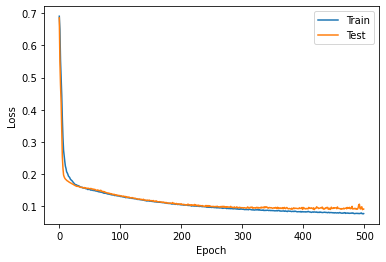

In [176]:
import matplotlib.pyplot as plt
plt.plot(history.epoch, history.history['loss'], label='Train')
plt.plot(history.epoch, history.history['val_loss'], label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Feature improtance
https://stackoverflow.com/questions/44119207/is-there-any-way-to-get-variable-importance-with-keras
https://stats.stackexchange.com/questions/191855/variable-importance-in-rnn-or-lstm

In [177]:
#pip install eli5

In [178]:
#import eli5
#from eli5.sklearn import PermutationImportance

In [179]:
#perm = PermutationImportance(model, random_state=1,scoring="accuracy").fit(X_train,y_train,)
#eli5.show_weights(perm, feature_names = X_train.columns.tolist())

## Find the threshold for dividing positive samples and neigative samples

In [180]:
predict = model.predict(X_test)
predict.shape

(738, 8)

In [181]:
predict[1]

array([3.1582525e-11, 3.4329682e-15, 0.0000000e+00, 3.0463299e-30,
       1.2206622e-13, 4.3235389e-13, 8.2957745e-04, 5.5999458e-03],
      dtype=float32)

In [182]:
predict[0]

array([8.1531310e-19, 1.4724492e-18, 0.0000000e+00, 1.5184271e-38,
       1.0930026e-22, 1.6616576e-24, 1.4088096e-07, 9.6509175e-05],
      dtype=float32)

In [183]:
month=['May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
Client = used_id[-y_test.shape[0]:]

preidct_df = pd.DataFrame(predict,columns=month,index=Client,)
True_df=pd.DataFrame(y_test,columns=month,index=Client)

In [184]:
preidct_df.describe()

,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
count,7.380000e+02,7.380000e+02,7.380000e+02,7.380000e+02,7.380000e+02,7.380000e+02,7.380000e+02,7.380000e+02
mean,9.148239e-02,8.664242e-02,9.879821e-02,7.854912e-02,5.593656e-02,5.411663e-02,6.901874e-02,2.407418e-02
std,2.518165e-01,2.357512e-01,2.489720e-01,2.122931e-01,1.759565e-01,1.794086e-01,1.712968e-01,5.712353e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.819680e-26,2.835864e-12
25%,1.028367e-29,1.011998e-24,0.000000e+00,0.000000e+00,6.166600e-33,2.947986e-37,9.863891e-12,1.313229e-06
50%,4.260103e-21,1.518884e-20,0.000000e+00,0.000000e+00,5.794129e-25,7.918147e-27,2.483166e-08,3.462157e-05
75%,4.700700e-10,2.904645e-12,1.936573e-19,8.002005e-14,3.347506e-10,1.465224e-10,1.244314e-03,7.416651e-03
max,9.589660e-01,9.686996e-01,9.572104e-01,9.952730e-01,9.697754e-01,9.712965e-01,7.319231e-01,2.337033e-01


In [185]:
preidct_df.head()

,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
DB10AF3E-0F92-E011-A5C6-B6A03279A8B3,8.153131e-19,1.472449e-18,0.000000e+00,1.518427e-38,1.093003e-22,1.661658e-24,1.408810e-07,0.000097
DB1CE471-B20F-434C-B4D4-9F6D00D10976,3.158252e-11,3.432968e-15,0.000000e+00,3.046330e-30,1.220662e-13,4.323539e-13,8.295774e-04,0.005600
F771E77B-341D-4672-B6AD-A43500AB411B,6.922687e-36,1.689509e-21,2.613664e-04,9.916862e-01,6.052732e-01,1.369843e-02,6.573859e-02,0.019985
F77DFB42-B83B-47FD-BBA9-A88D00E983C1,3.467755e-23,4.885792e-21,0.000000e+00,0.000000e+00,6.313094e-28,8.425087e-31,1.573985e-09,0.000012
E9D0885E-57E7-4EE6-A384-A61200D8ABF1,3.375984e-14,1.439499e-13,1.586240e-35,3.311717e-25,1.028942e-14,1.832767e-16,2.399702e-05,0.001307


In [186]:
True_df.head()

,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
DB10AF3E-0F92-E011-A5C6-B6A03279A8B3,0,0,0,0,0,0,0,0
DB1CE471-B20F-434C-B4D4-9F6D00D10976,0,0,0,0,0,0,0,0
F771E77B-341D-4672-B6AD-A43500AB411B,0,0,0,1,1,0,0,0
F77DFB42-B83B-47FD-BBA9-A88D00E983C1,0,0,0,0,0,0,0,0
E9D0885E-57E7-4EE6-A384-A61200D8ABF1,0,0,0,0,0,0,0,0


## Build a dataframe which contains two columns: Predited_value and True_Value for modelling

In [187]:
# Combine dataframe to a single column
len=preidct_df.shape[0]
name_all=[] # predicted values
value_all=[] # months
true_all=[]
for elem in month:
  value_all+=(list(preidct_df[str(elem)]))
  true_all += (list(True_df[str(elem)]))
  name_all += [elem]*len

In [188]:
# build the client column
client=[]
for i in range(preidct_df.shape[1]):
  client+=Client

In [189]:
# Build the datafame
dataset=pd.DataFrame(zip(value_all,name_all,true_all),columns=['Predict','Month','Label'])
dataset['Client_id']=client
dataset.set_index(['Month','Client_id'],inplace=True)
dataset.head()

Predict  Label
Month Client_id                                                
May   DB10AF3E-0F92-E011-A5C6-B6A03279A8B3  8.153131e-19      0
      DB1CE471-B20F-434C-B4D4-9F6D00D10976  3.158252e-11      0
      F771E77B-341D-4672-B6AD-A43500AB411B  6.922687e-36      0
      F77DFB42-B83B-47FD-BBA9-A88D00E983C1  3.467755e-23      0
      E9D0885E-57E7-4EE6-A384-A61200D8ABF1  3.375984e-14      0

## Spliting the predicted value to Test and Train sets for finding the threshold

In [190]:
from sklearn.model_selection import train_test_split

In [191]:
rate=0.2
train, test = train_test_split(dataset, test_size=rate, random_state=5)

In [192]:
'''splitting the dataset to X and Y'''
# X
train_xth = train.Predict
test_xth = test.Predict

# Y
train_yth = train.Label
test_yth = test.Label

print('The sizes for training dataset and test dataset:\n',train_xth.shape,test_xth.shape)

The sizes for training dataset and test dataset:
 (4723,) (1181,)


### Plotting the Loss

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


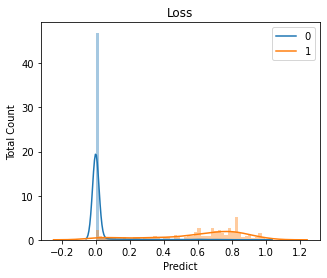

In [193]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 4))
for i in [0,1]:
  sns.distplot(train_xth.loc[train.Label==i], bins=50,kde=True)
ax.set_ylabel('Total Count')
ax.set_title('Loss')
ax.legend('01')
#plt.savefig('loss'.png')

### Finding the best threshold

In [194]:
# from the above plot we can choose the threshold to be 0.2 or greater
'''Generate the list for thresholds'''
threshold = []
num = 4000
start=0.2
for i in range(num):
  val= start+0.0001*i
  threshold.append(val)


In [195]:
# generate the list of f1_scores 
from sklearn.metrics import f1_score
f1_scores=[]
for thres in threshold:
  Predited_label = []
  for elem in test_xth:
    if elem < thres:
      Predited_label.append(0)
    else:
      Predited_label.append(1)
  f1s=f1_score(test_yth, Predited_label, zero_division=0)
  f1_scores.append(f1s)

In [196]:
# get the corrodinate of the largest f1_score
y=max(f1_scores)
max_index = f1_scores.index(max(f1_scores))
x=threshold[max_index]

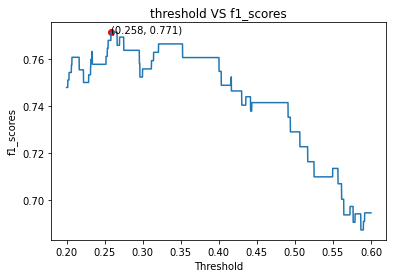

In [205]:
plt.plot(threshold,f1_scores)
plt.title('threshold VS f1_scores')
plt.scatter(x, y, c='red')
plt.xlabel('Threshold')
plt.ylabel('f1_scores')
plt.text(x, y, '({:5.3f}, {:5.3f})'.format(x, y))
plt.savefig('threshold_choose.png')
plt.show()

In [198]:
print(f'The best f1_scores is{y: 5.4f} for threshold is{x: 5.4f}.')

The best f1_scores is 0.7713 for threshold is 0.2583.


### Show the performance of the model

In [199]:
# label the prediction with the choosen threshold
predited_label=[]
incident_index=[]# incident list
for elem in test_xth:
  if elem < x:
    predited_label.append(0)
  else:
    predited_label.append(1)
    indx = test_xth.loc[(test_xth.loc[:]==elem),:].index.values.tolist()
    incident_index+=indx

In [200]:
from sklearn.metrics import classification_report

report = classification_report(test_yth, predited_label,labels=[1,0])
print(report)

              precision    recall  f1-score   support

           1       0.73      0.82      0.77       105
           0       0.98      0.97      0.98      1076

    accuracy                           0.96      1181
   macro avg       0.86      0.89      0.87      1181
weighted avg       0.96      0.96      0.96      1181



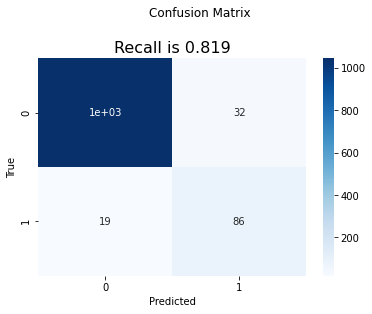

In [203]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(test_yth, predited_label)
recal = cm[1][1]/sum(cm[1])

sns.heatmap(cm, annot=True,cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title(f'Recall is {recal:0.3f}',y=1.05, fontsize=16)
plt.suptitle('Confusion Matrix',y=1.06)

plt.savefig('Confusion_matrix.png')
plt.show()

The best result is when epcho is 500, threshold is 0.258, and f1_score is 0.771  and recall is 0.81. (drop out rate 0.2)

## The clients who should pay attention to.

In [202]:
print('The risky clients in each month:')
df=pd.DataFrame(incident_index,columns=['Month', 'Client_id'])
df.sort_values(by=['Month'])

The risky clients in each month:


,Month,Client_id
28,Aug,E0CE67F9-2476-40D2-94B9-9F6C00A0001D
82,Aug,F0BB6E45-C18C-46DD-8417-A07F00C9EE89
29,Aug,F9820D32-26C4-4CE9-959C-A60400B41C28
55,Aug,F8A15B65-EC5D-4540-88C6-E25F8EB44974
22,Aug,F3A41837-8652-48B1-A74E-A89300E7E965
...,...,...
12,Sep,DF97393F-9427-409D-B221-A44800E853C7
13,Sep,F5A7C654-DE9F-4E73-BBE3-A8CC00BC3179
78,Sep,DF97393F-9427-409D-B221-A44800E853C7
7,Sep,DCB47745-C27B-46F3-B02C-5ADBA189D1A0
